In [1]:
# Intialization
import os
import sys

os.environ["SPARK_HOME"] = "/home/talentum/spark"
os.environ["PYLIB"] = os.environ["SPARK_HOME"] + "/python/lib"
# In below two lines, use /usr/bin/python2.7 if you want to use Python 2
os.environ["PYSPARK_PYTHON"] = "/usr/bin/python3.6" 
os.environ["PYSPARK_DRIVER_PYTHON"] = "/usr/bin/python3"
sys.path.insert(0, os.environ["PYLIB"] +"/py4j-0.10.7-src.zip")
sys.path.insert(0, os.environ["PYLIB"] +"/pyspark.zip")

# NOTE: Whichever package you want mention here.
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0 pyspark-shell' 
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'
os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.3 pyspark-shell'
# os.environ['PYSPARK_SUBMIT_ARGS'] = '--packages com.databricks:spark-xml_2.11:0.6.0,org.apache.spark:spark-avro_2.11:2.4.0 pyspark-shell'

In [2]:
#Entrypoint 2.x
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("TimeSeriesPreprocessing_holtwintermodel").enableHiveSupport().getOrCreate()

# On yarn:
# spark = SparkSession.builder.appName("Spark SQL basic example").enableHiveSupport().master("yarn").getOrCreate()
# specify .master("yarn")

sc = spark.sparkContext

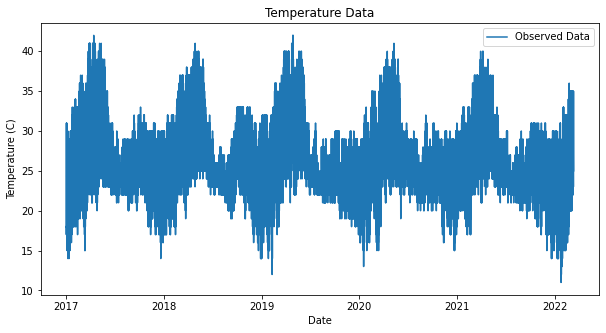

In [4]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, to_timestamp
import pandas as pd
import matplotlib.pyplot as plt 


# Load the data into Spark DataFrame
file_path = 'file:///home/talentum/pune.csv'
data_spark = spark.read.csv(file_path, header=True, inferSchema=True)

# Convert 'date_time' column to timestamp
data_spark = data_spark.withColumn('date_time', to_timestamp(col('date_time')))

# Drop rows with missing 'date_time'
data_spark = data_spark.dropna(subset=['date_time'])

# Rename columns
data_spark = data_spark.withColumnRenamed('date_time', 'ds').withColumnRenamed('tempC', 'y')

# Ensure 'y' column is numeric
data_spark = data_spark.withColumn('y', col('y').cast('double'))

# Drop rows with NaNs in 'y'
data_spark = data_spark.dropna(subset=['y'])

# Set 'ds' column as index (we need to collect to Pandas DataFrame for this operation)
data_spark = data_spark.toPandas()

# Set index and sort
data_spark.set_index('ds', inplace=True)
data_spark.index = pd.to_datetime(data_spark.index)
data_spark.sort_index(inplace=True)

# Plot the data to understand trends and seasonality
plt.figure(figsize=(10, 5))
plt.plot(data_spark.index, data_spark['y'], label='Observed Data')
plt.title('Temperature Data')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

# Split the data into training and test sets
train_size = int(len(data_spark) * 0.8)
train, test = data_spark[:train_size], data_spark[train_size:]


/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Squared Error (Additive): 55.70266666010984


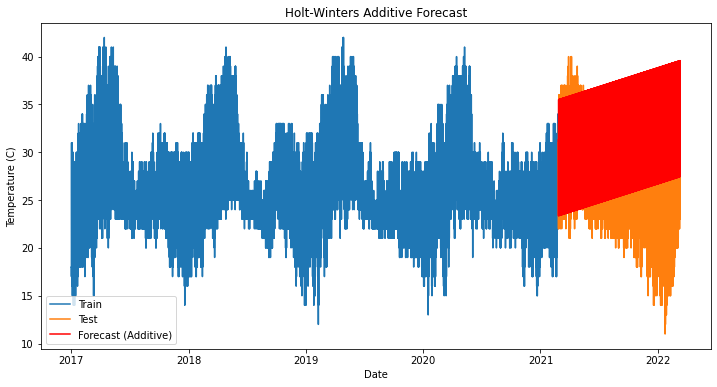

/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/holtwinters/model.py:429: FutureWarning: After 0.13 initialization must be handled at model creation
  FutureWarning,
/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


Mean Squared Error (Multiplicative): 61.25516783006724


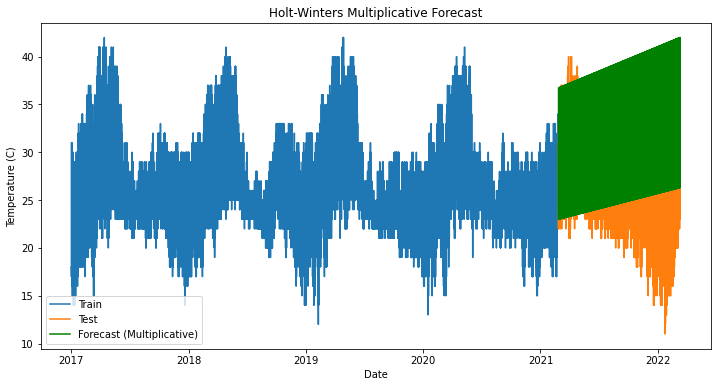

/home/talentum/.local/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:379: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  ValueWarning)


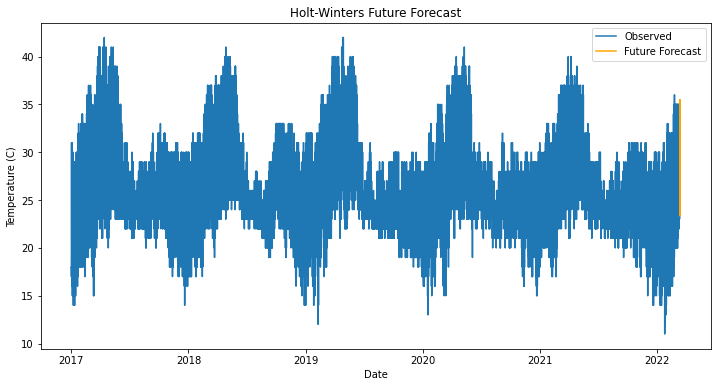

Best model saved to 'holt_winters_best_model.pkl'


In [6]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
import joblib

# Holt-Winters Model - Additive Seasonal Model
model_add = ExponentialSmoothing(train['y'], 
                                  trend='add', 
                                  seasonal='add', 
                                  seasonal_periods=24)  # Adjust seasonal_periods as needed
fit_add = model_add.fit()

# Forecast
forecast_add = fit_add.forecast(steps=len(test))

# Calculate Mean Squared Error for Additive Model
mse_add = mean_squared_error(test['y'], forecast_add)
print(f'Mean Squared Error (Additive): {mse_add}')

# Plot the results for Additive Model
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test')
plt.plot(test.index, forecast_add, label='Forecast (Additive)', color='red')
plt.title('Holt-Winters Additive Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

# Holt-Winters Model - Multiplicative Seasonal Model (if appropriate)
model_mul = ExponentialSmoothing(train['y'], 
                                  trend='add', 
                                  seasonal='mul', 
                                  seasonal_periods=24)  # Adjust seasonal_periods as needed
fit_mul = model_mul.fit()

# Forecast
forecast_mul = fit_mul.forecast(steps=len(test))

# Calculate Mean Squared Error for Multiplicative Model
mse_mul = mean_squared_error(test['y'], forecast_mul)
print(f'Mean Squared Error (Multiplicative): {mse_mul}')

# Plot the results for Multiplicative Model
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['y'], label='Train')
plt.plot(test.index, test['y'], label='Test')
plt.plot(test.index, forecast_mul, label='Forecast (Multiplicative)', color='green')
plt.title('Holt-Winters Multiplicative Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

# Future Forecasting with the best model
best_model = fit_add if mse_add < mse_mul else fit_mul
forecast_steps = 30  # Forecasting the next 30 periods
future_forecast = best_model.forecast(steps=forecast_steps)

# Create future dates index
future_index = pd.date_range(start=data_spark.index[-1] + pd.DateOffset(hours=1), 
                             periods=forecast_steps, freq='H')
future_forecast.index = future_index

# Plot Future Forecast
plt.figure(figsize=(12, 6))
plt.plot(data_spark.index, data_spark['y'], label='Observed')
plt.plot(future_forecast.index, future_forecast, label='Future Forecast', color='orange')
plt.title('Holt-Winters Future Forecast')
plt.xlabel('Date')
plt.ylabel('Temperature (C)')
plt.legend()
plt.show()

# Save the best model for future use
joblib.dump(best_model, 'holt_winters_best_model.pkl')
print("Best model saved to 'holt_winters_best_model.pkl'")
